In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import gpflow

import warnings
warnings.filterwarnings("ignore")

2025-04-13 07:50:52.548480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 07:50:52.562425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744552252.573990   56154 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744552252.577434   56154 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 07:50:52.591185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'
from sampling_pyfunctions import *

In [3]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

In [ ]:

def hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize=False):
    
    # LAI
    loaded_emulator = tf.saved_model.load(emulator_path+'lai/' + biome_name)
    y_pred, y_pred_var = loaded_emulator.predict(sample.values)
    obs_mean, obs_var = obs.LAI_mean.sel(biome=b).values, obs.LAI_stdev.sel(biome=b).values**2
    lai_I = np.abs(y_pred.numpy().flatten() - obs_mean) / np.sqrt(y_pred_var.numpy().flatten() + obs_var)
    
    # GPP
    loaded_emulator = tf.saved_model.load(emulator_path+'gpp/' + biome_name)
    y_pred, y_pred_var = loaded_emulator.predict(sample.values)
    obs_mean, obs_var = obs.GPP_mean.sel(biome=b).values, obs.GPP_stdev.sel(biome=b).values**2
    gpp_I = np.abs(y_pred.numpy().flatten() - obs_mean) / np.sqrt(y_pred_var.numpy().flatten() + obs_var)
    
    # biomass
    loaded_emulator = tf.saved_model.load(emulator_path+'biomass/' + biome_name)
    y_pred, y_pred_var = loaded_emulator.predict(sample.values)
    obs_mean, obs_var = obs.biomassC_mean.sel(biome=b).values, obs.biomassC_stdev.sel(biome=b).values**2
    biomass_I = np.abs(y_pred.numpy().flatten() - obs_mean) / np.sqrt(y_pred_var.numpy().flatten() + obs_var)

    mask = (lai_I < 3) & (gpp_I < 3) & (biomass_I < 3)
    plausible_ix = np.where(mask)[0]
    if len(plausible_ix) == 0: # if there are no plausible_ix samples then continue
        selected_sample = pd.DataFrame({np.nan})
    elif minimize == 1:
        # Find the index among plausible_ix with the minimum total implausibility score.
        sum_I = lai_I + gpp_I + biomass_I
        min_index = np.argmin(sum_I[plausible_ix])
        ix = plausible_ix[min_index]
        selected_sample = sample.iloc[[ix]]
    else: # take one random sample from plausible_ix
        ix = np.random.choice(plausible_ix) 
        selected_sample = sample.iloc[[ix]]
    
    return selected_sample

In [36]:
#############################################

def calibration_tree(usample,psample,n_psamp,u_params,pft_param_names,emulator_path,obs,biome_configs,minimize=False,):

    ######
    # Atree
    b = 1 # 'Tropical rainforest'
    biome_name = biome_configs[b]['name']
    u = np.repeat(usample.values,repeats=n_psamp,axis=0)
    s = np.concatenate([u,psample.values],axis=1)
    columns = np.concatenate((u_params,pft_param_names[4]))
    sample = pd.DataFrame(s,columns=columns)
    biome1_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome1_sample.isna().all().all():
        return pd.DataFrame({np.nan})
    
    ####
    b = 2   # 'Tropical savanna'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome1_sample,pft_param_names,u_params,n_psamp,psample)
    biome2_sample = hmatch_biome(b, biome_name,sample, emulator_path, obs, minimize)
    if biome2_sample.isna().all().all():
        return pd.DataFrame({np.nan})
        
    ####
    b = 3   # 'Subtropical savanna'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome2_sample,pft_param_names,u_params,n_psamp,psample)
    biome3_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome3_sample.isna().all().all():
        return pd.DataFrame({np.nan})

    ####
    b = 5  # 'Grasslands'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome3_sample,pft_param_names,u_params,n_psamp,psample)
    biome5_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome5_sample.isna().all().all():
        return pd.DataFrame({np.nan})
    
    ####
    b = 6  # 'Shrubland'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome5_sample,pft_param_names,u_params,n_psamp,psample)
    biome6_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome6_sample.isna().all().all():
        return pd.DataFrame({np.nan})
    
    ####
    b = 4   # 'Broadleaf evergreen temperate tree'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome6_sample,pft_param_names,u_params,n_psamp,psample)
    biome4_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome4_sample.isna().all().all():
        return pd.DataFrame({np.nan})

    ###########
    # Btree
    b = 12 # 'Boreal shrubland'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome1_sample,pft_param_names,u_params,n_psamp,psample)
    biome12_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome12_sample.isna().all().all():
        return pd.DataFrame({np.nan})
    
    ####
    b = 13 # 'Tundra'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome12_sample,pft_param_names,u_params,n_psamp,psample)
    biome13_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome13_sample.isna().all().all():
        return pd.DataFrame({np.nan})
    
    ####
    b = 9  # 'Siberian larch'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome13_sample,pft_param_names,u_params,n_psamp,psample)
    biome9_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome9_sample.isna().all().all():
        return pd.DataFrame({np.nan})
        
    ####
    b = 10 # 'Boreal forest'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome13_sample,pft_param_names,u_params,n_psamp,psample)
    biome10_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome10_sample.isna().all().all():
        return pd.DataFrame({np.nan})
    
    ############
    # C tree
    b = 8 # 'Conifer forest'
    biome_name = biome_configs[b]['name']
    cols = np.concatenate([u_params,pft_param_names[13],pft_param_names[14]]).tolist()
    Aset = biome4_sample[cols]
    cols = np.concatenate([pft_param_names[2]]).tolist()
    Bset = biome10_sample[cols]
    merged = pd.concat([Aset.reset_index(drop=True), Bset.reset_index(drop=True)], axis=1)
    sample = create_biome_sample(b,merged,pft_param_names,u_params,n_psamp,psample)
    biome8_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome8_sample.isna().all().all():
        return pd.DataFrame({np.nan})

    ####
    b = 7 # 'Mixed deciduous temperate forest'
    biome_name = biome_configs[b]['name']
    sample = create_biome_sample(b,biome8_sample,pft_param_names,u_params,n_psamp,psample)
    biome7_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome7_sample.isna().all().all():
        return pd.DataFrame({np.nan})
    
    ####
    b = 11 # 'Broadleaf deciduous boreal trees' # 2,8,12,13
    biome_name = biome_configs[b]['name']
    cols = np.concatenate([u_params,pft_param_names[2],pft_param_names[13]]).tolist()
    b8 = biome8_sample[cols]
    cols = np.concatenate([pft_param_names[12]]).tolist()
    b10 = biome10_sample[cols]
    merged = pd.concat([b8.reset_index(drop=True), b10.reset_index(drop=True)], axis=1)
    sample = create_biome_sample(b,merged,pft_param_names,u_params,n_psamp,psample)
    biome11_sample = hmatch_biome(b, biome_name, sample, emulator_path, obs, minimize)
    if biome11_sample.isna().all().all():
        return pd.DataFrame({np.nan})

    b_samples = [0.0,biome1_sample, biome2_sample, biome3_sample, biome4_sample, biome5_sample, biome6_sample, 
             biome7_sample, biome8_sample, biome9_sample, biome10_sample, biome11_sample, biome12_sample, biome13_sample]

    return b_samples


### setup

In [4]:
# Define biome settings: biome name, index, and PFTs 
biome_configs = [
    {'name': 'NaN','index':0, 'pfts':[np.NaN]},
    {'name': 'Tropical rainforest', 'index':1, 'pfts': [4]},
    {'name': 'Tropical savanna', 'index':2, 'pfts': [4,14]},
    {'name': 'Subtropical savanna', 'index':3, 'pfts': [4,6,14]},
    {'name': 'Broadleaf evergreen temperate tree', 'index':4, 'pfts':[5, 13, 14]},
    {'name': 'Grasslands', 'index': 5, 'pfts':[13,14]},
    {'name': 'Shrubland', 'index':6, 'pfts': [10,13,14]},
    {'name': 'Mixed deciduous temperate forest', 'index':7, 'pfts': [1, 7, 13, 14]},
    {'name': 'Conifer forest', 'index':8, 'pfts': [1, 2, 13, 14]},
    {'name': 'Siberian larch', 'index':9, 'pfts': [3,11,12]},
    {'name': 'Boreal forest', 'index':10, 'pfts': [2,11,12]},
    {'name': 'Broadleaf deciduous boreal trees', 'index':11, 'pfts': [2, 8, 12, 13]},
    {'name': 'Boreal shrubland', 'index': 12, 'pfts': [12]},
    {'name': 'Tundra', 'index': 13, 'pfts': [11, 12]},
]

In [5]:
#############################################
# Setup
#############################################
# load observational data
obs = xr.open_dataset('../wave2_obsStatistics_sudokuBiomes.nc')

# info on parameter names
params_lhc = pd.read_csv('/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt').drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

pft_param_names = {i: [f"{param}_{i}" for param in pft_params] for i in range(1, 15)}

# Biome info
file='/glade/u/home/linnia/ctsm6_ppe/utils/sudoku_biomes.nc'
biomes=xr.open_dataset(file)
biome_names = biomes.biome_names.values

import pickle
with open("/glade/u/home/linnia/ctsm6_ppe/utils/biome_pft_dict.pkl", "rb") as f:
    biome_pfts = pickle.load(f)



### Calibration tree

In [5]:
# create universal sample
from scipy.stats import qmc
n_dims = 41
n_samples = 100000

sampler = qmc.LatinHypercube(d=n_dims)

s = sampler.random(n=n_samples)
usamples = pd.DataFrame(s,columns=u_params)

In [6]:
usamples.to_csv('universal_samples_LHC100000.csv',index=False)

In [9]:
usamples = pd.read_csv('universal_samples_LHC10000.csv')

In [24]:
%%time
emulator_path = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/emulators_biome'

n_psamp = 1000
key = np.array(1)
n_usets = 10

param_sets = []
for u in range(key*n_usets,key*n_usets+n_usets):
    usample = usamples.iloc[[u]]
    psample = pd.DataFrame(np.random.rand(n_psamp,len(pft_params)),columns=pft_params)

    b_samples = calibration_tree(usample,psample,n_psamp,u_params,pft_param_names,emulator_path,obs,biome_configs)
    # if none of the samples are plausible for any given biome, continue to next universal set
    if len(b_samples)==1:
        continue
    else:
        s = create_master_sample(b_samples,pft_param_names)
    
        param_sets.append(s)

master_sample = pd.concat(param_sets)

CPU times: user 2min 15s, sys: 1.29 s, total: 2min 17s
Wall time: 2min 26s


In [14]:
outdir = '/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/'
#master_sample.to_csv(out_dir+'hmatch_mastersample_'+str(key)+'.csv',index=False)
print(outdir+'hmatch_mastersample_'+str(key)+'.csv')

/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/hmatch_mastersample_1.csv


### Emulate to check

In [16]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_lhc = (60*60*24)*lhc_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
biomass_lhc = (1/1000)*lhc_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()


In [36]:
#master_sample = pd.read_csv('calibrated_samples_1.csv')

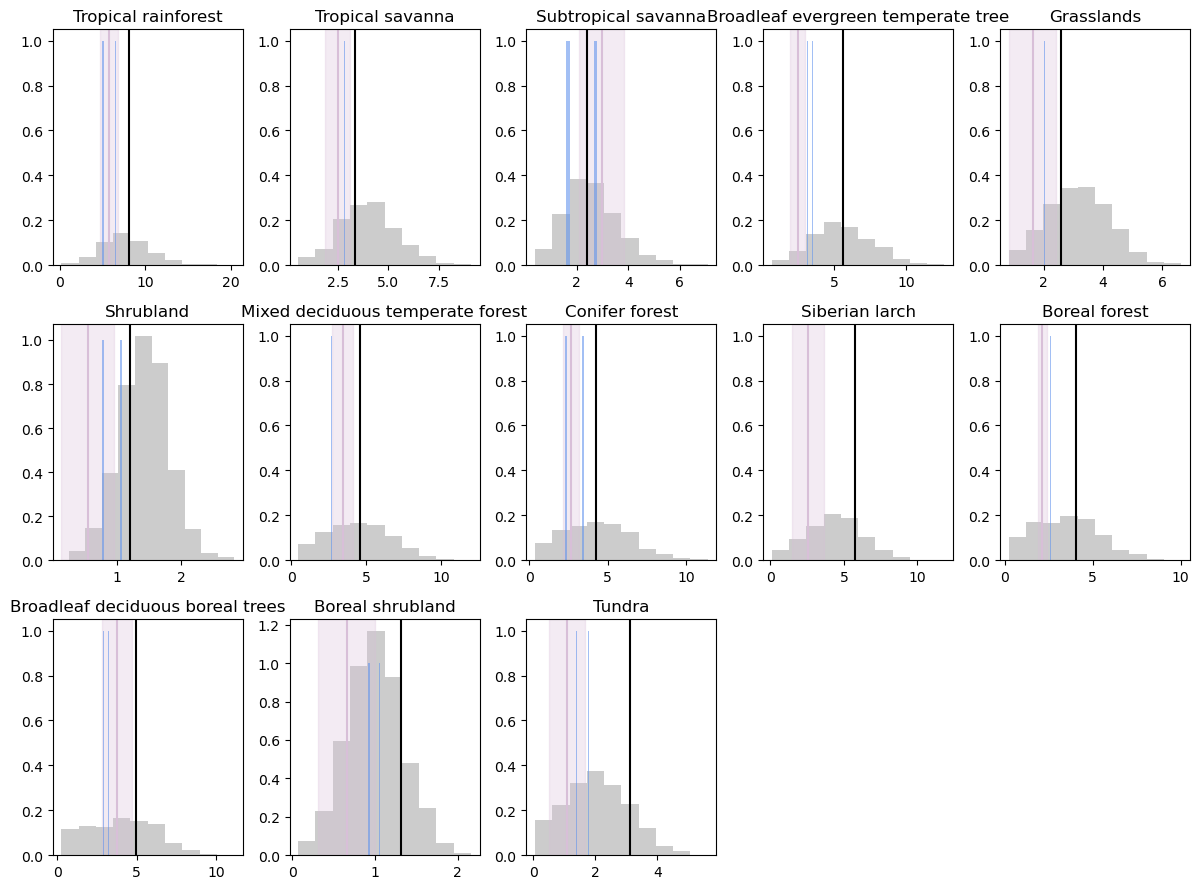

In [19]:
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/emulators_biomelai/'

plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.LAI_mean.sel(biome=b).values
    obs_var = obs.LAI_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = master_sample[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    plt.axvline(lai_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue')
    
    plt.title(biome)

plt.tight_layout()

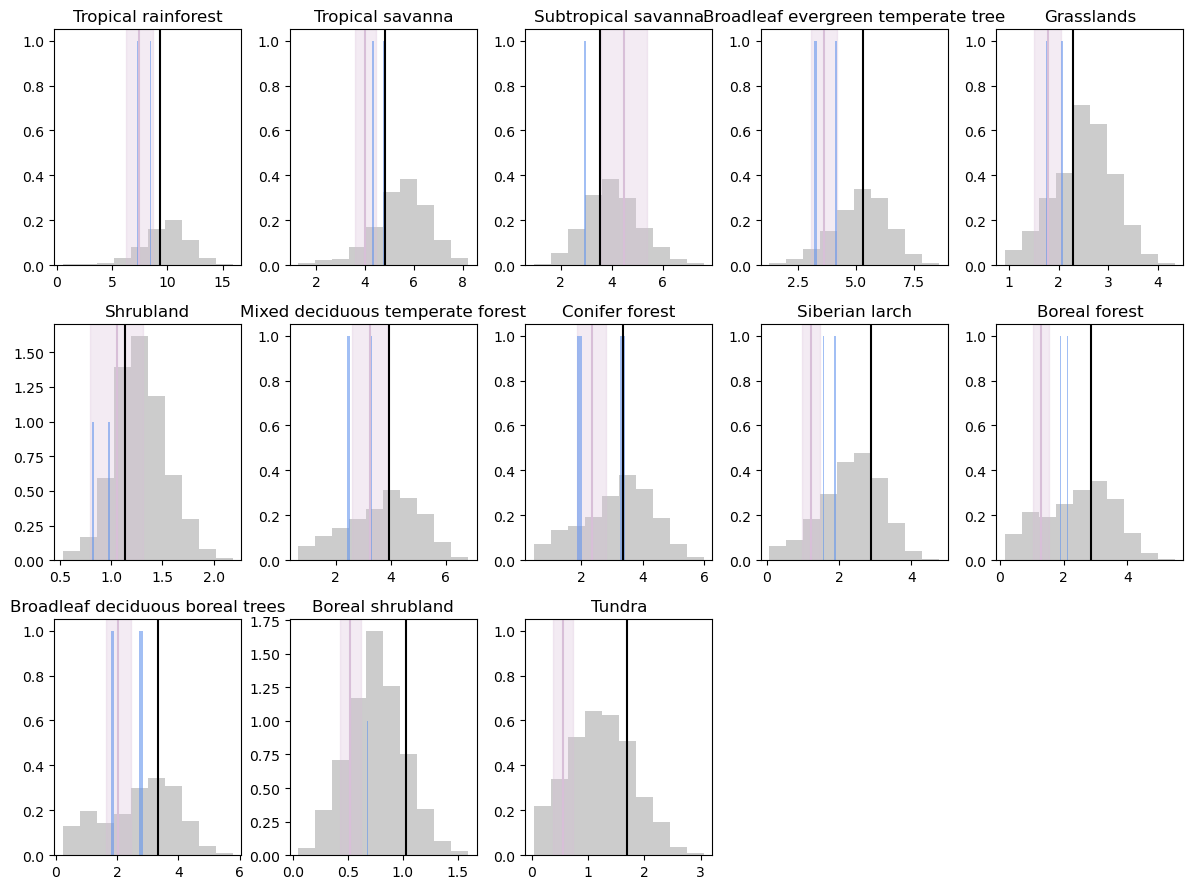

In [20]:
# emulate GPP
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/emulators_biomegpp/'

plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.GPP_mean.sel(biome=b).values
    obs_var = obs.GPP_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = master_sample[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(gpp_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    plt.axvline(gpp_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue')
    
    plt.title(biome)

plt.tight_layout()

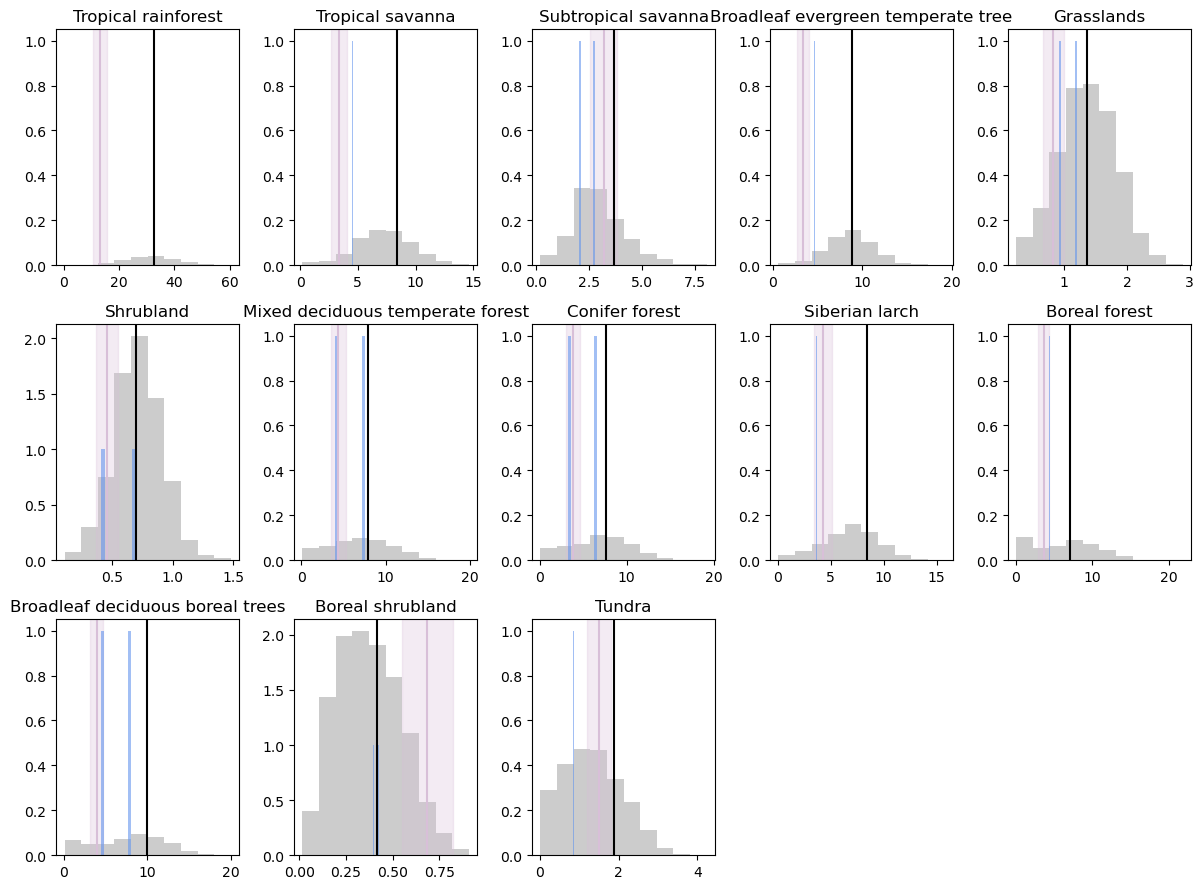

In [21]:
# emulate Biomass
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/emulators_biomebiomass/'

plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.biomassC_mean.sel(biome=b).values
    obs_var = obs.biomassC_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = master_sample[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(biomass_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    plt.axvline(biomass_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue')
    
    plt.title(biome)

plt.tight_layout()

### plot posteriors

In [6]:
indir = '/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/'
files = np.sort(glob.glob(indir + 'hmatch_mastersample_*'))
df_list = [pd.read_csv(f) for f in files]
master_sample = pd.concat(df_list, ignore_index=True)

In [8]:
np.shape(master_sample)

(12959, 236)

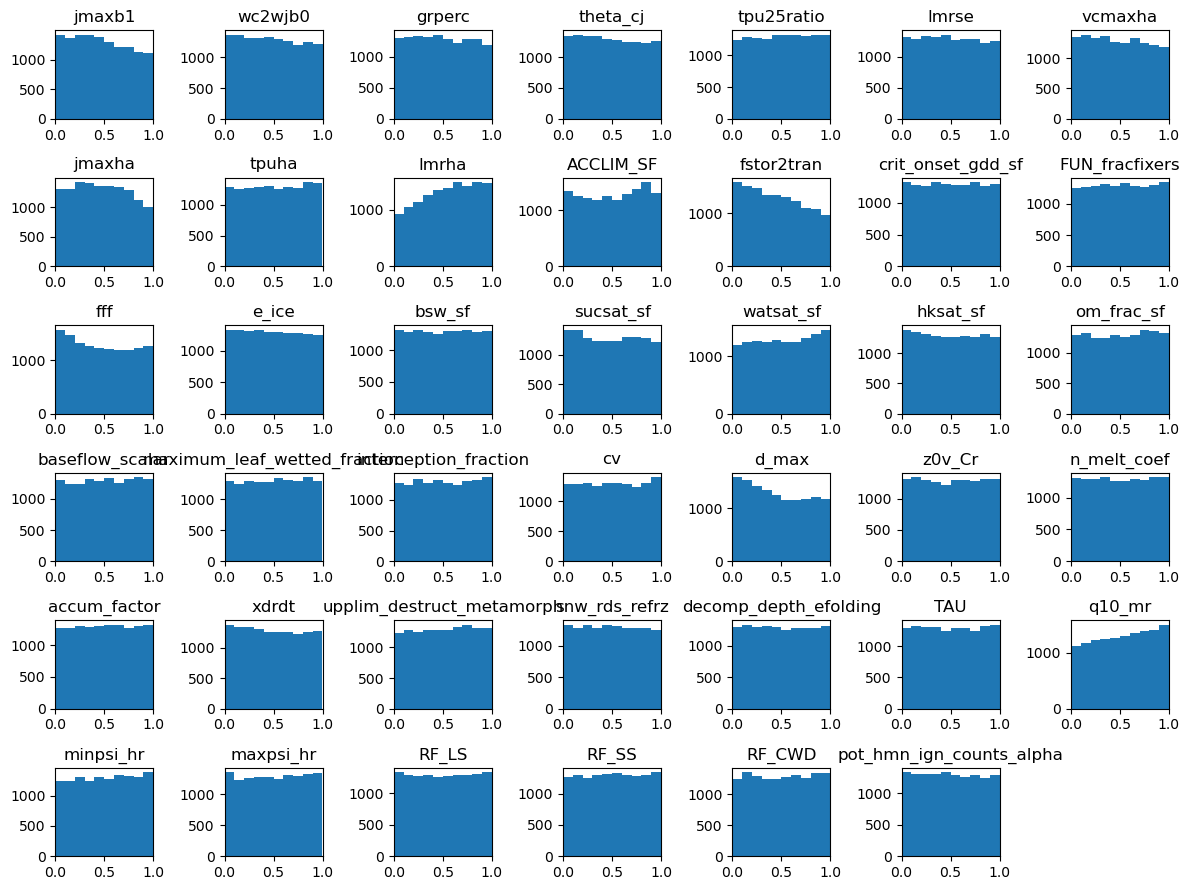

In [9]:

plt.figure(figsize=(12,9))
for i in range(len(u_params)):
    plt.subplot(6,7,i+1)
    plt.hist(master_sample[u_params[i]])
    plt.title(u_params[i])
    plt.xlim([0,1])
plt.tight_layout()
plt.savefig('../figs/posteriors_uparams_all.png')

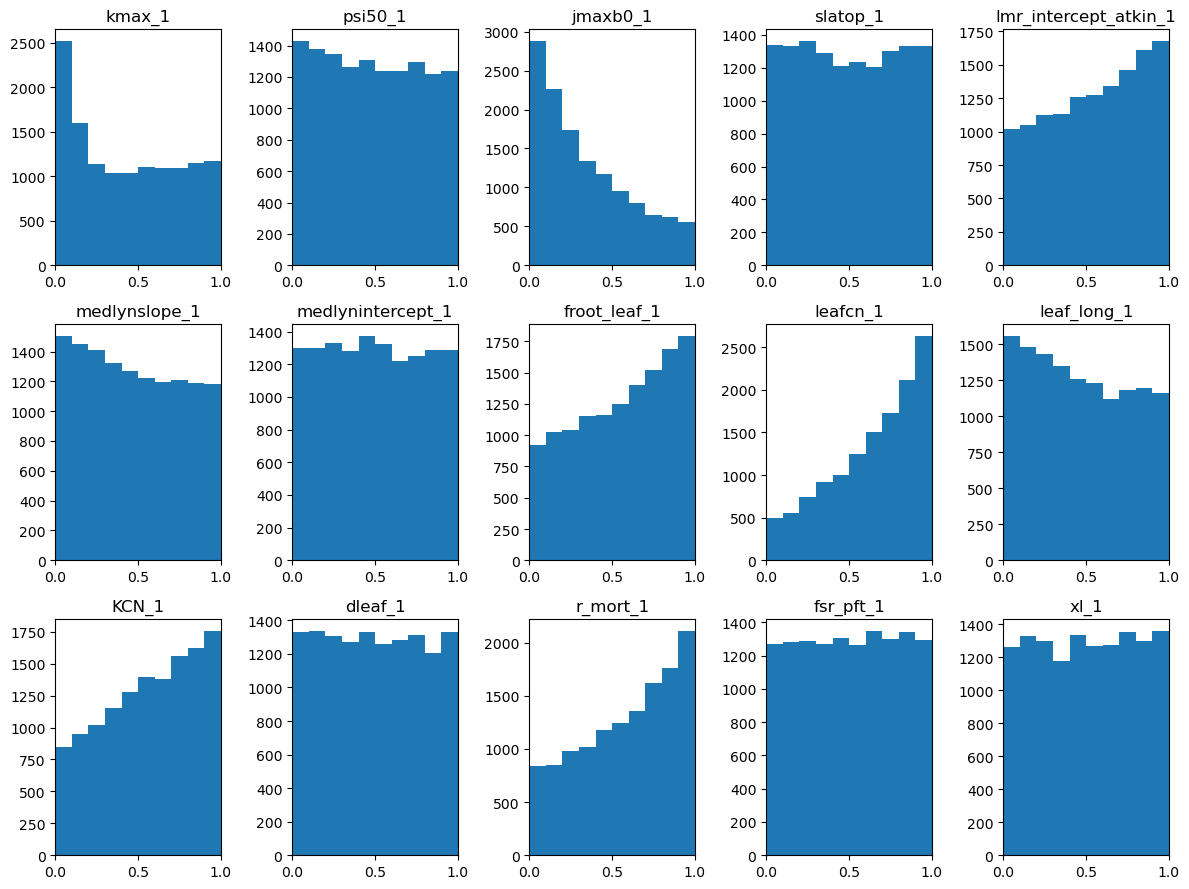

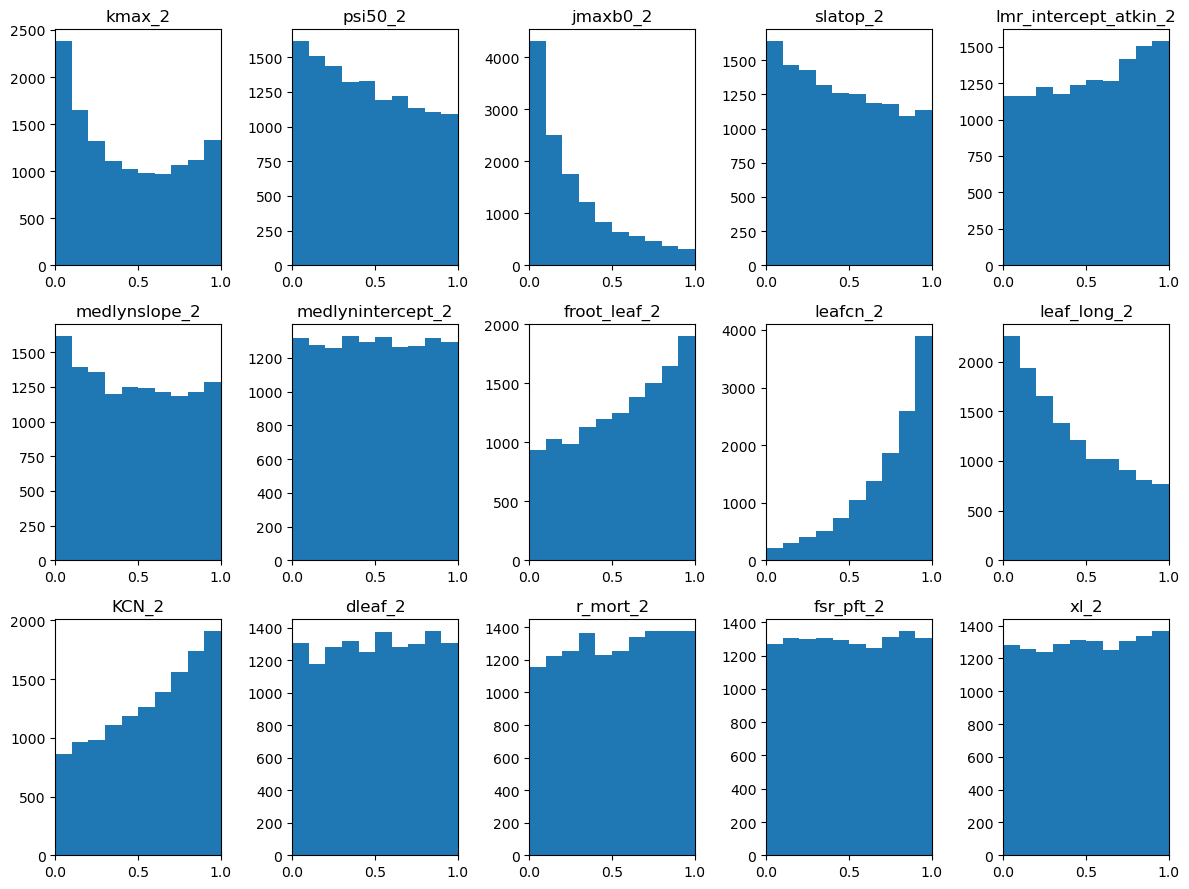

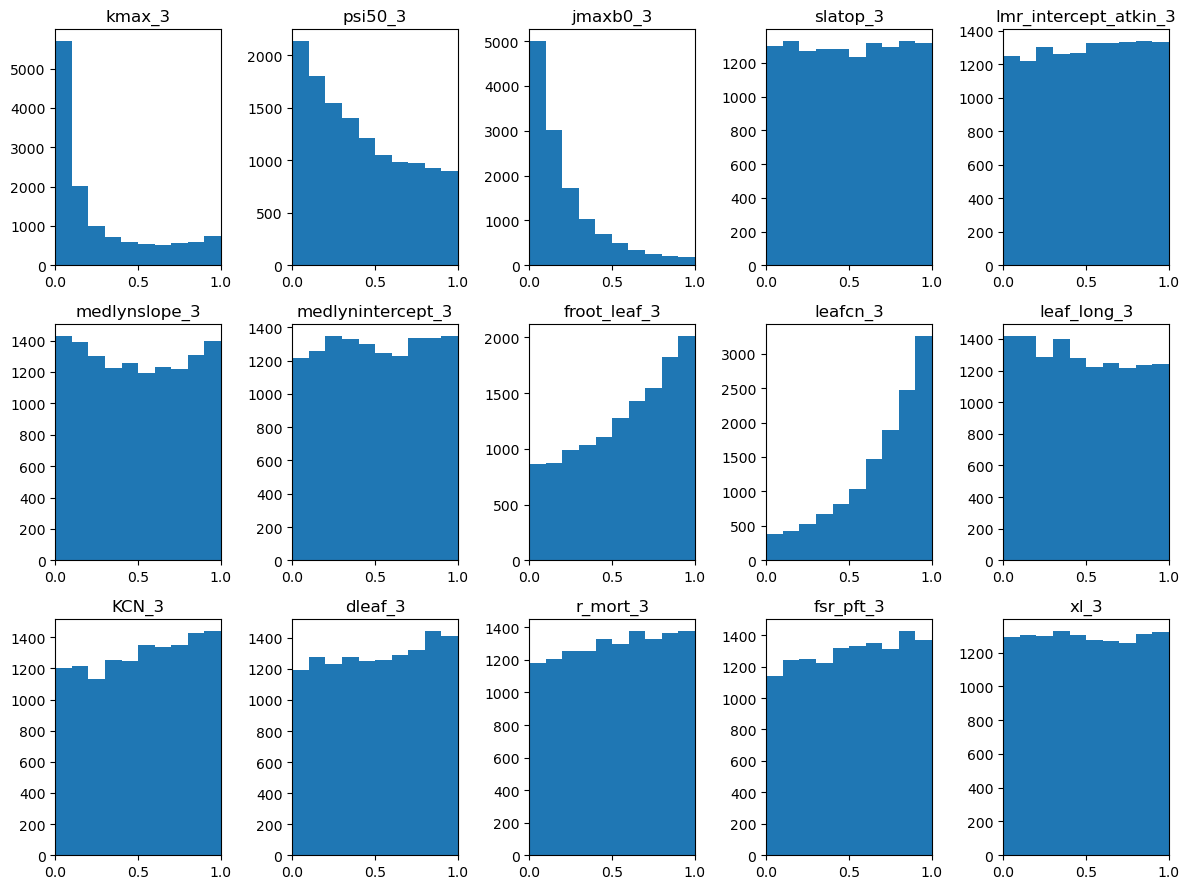

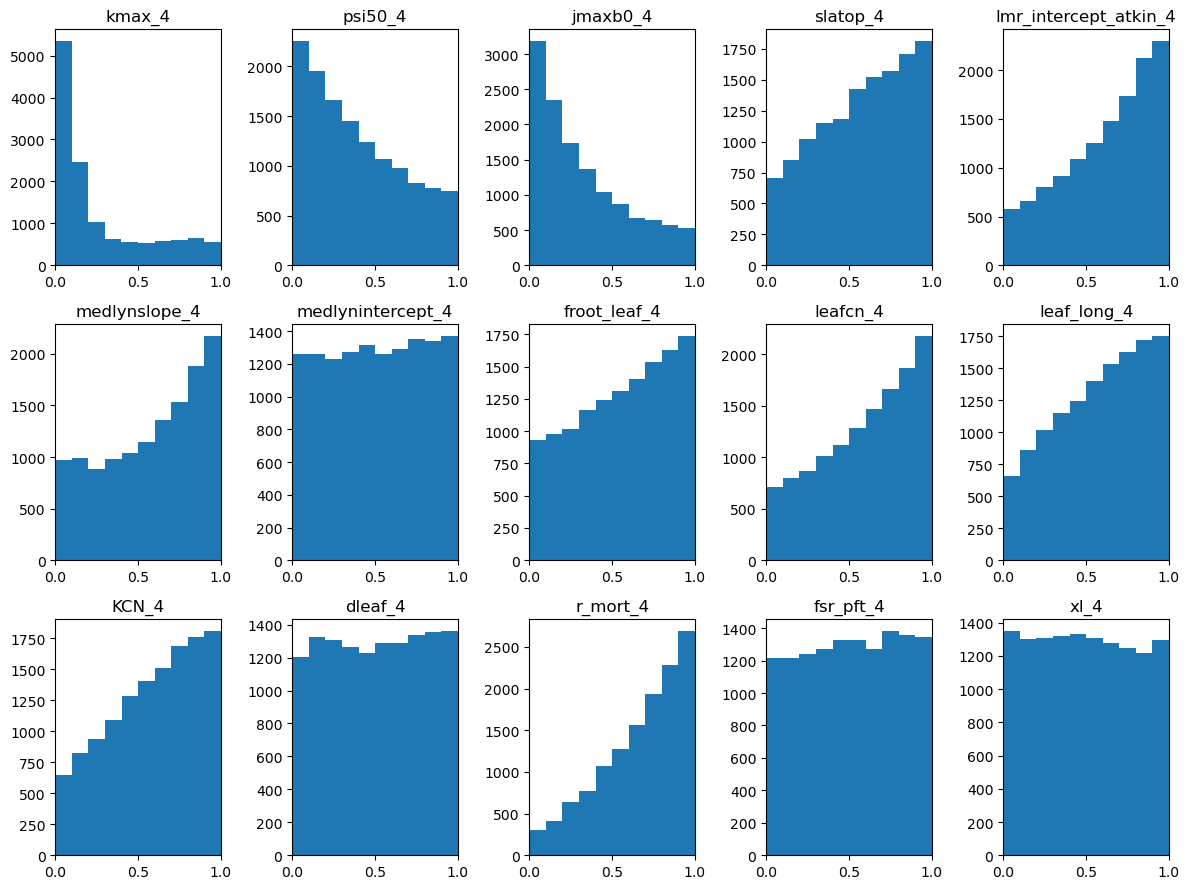

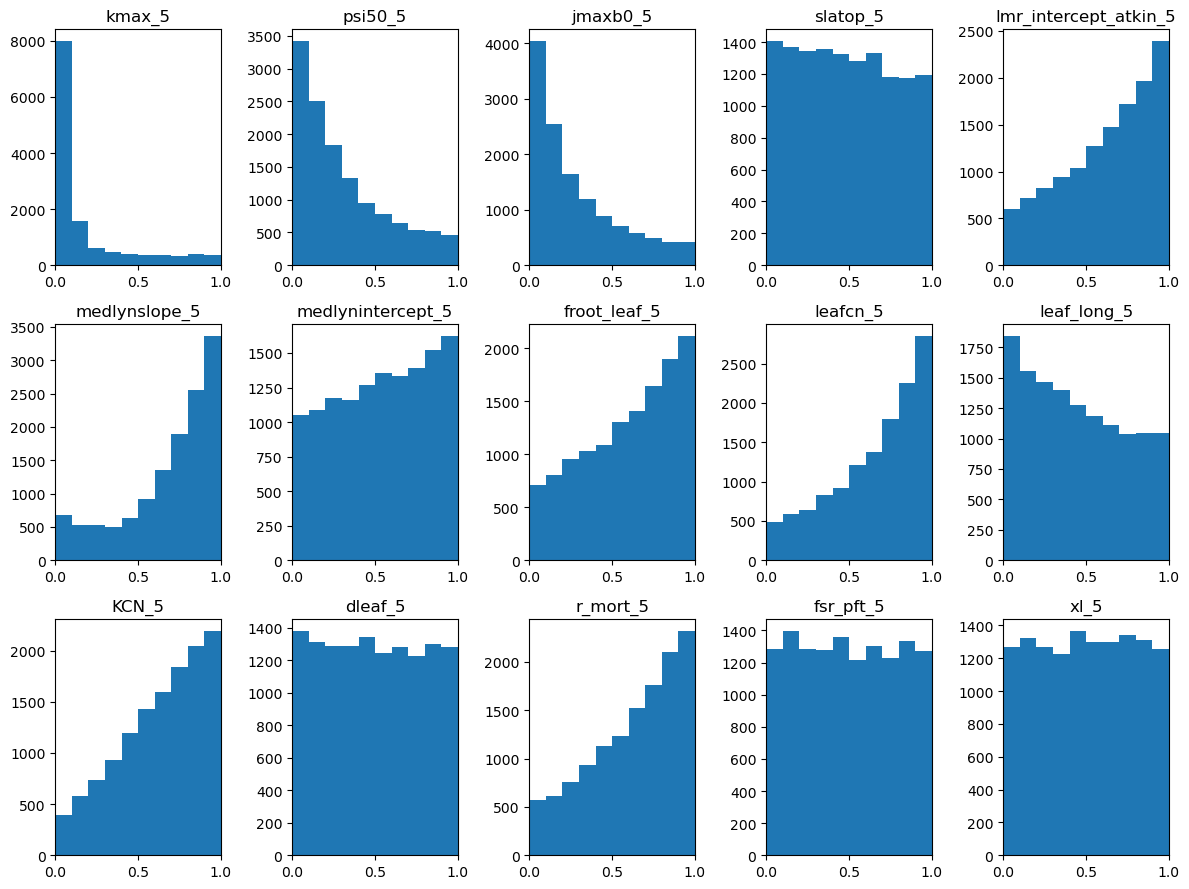

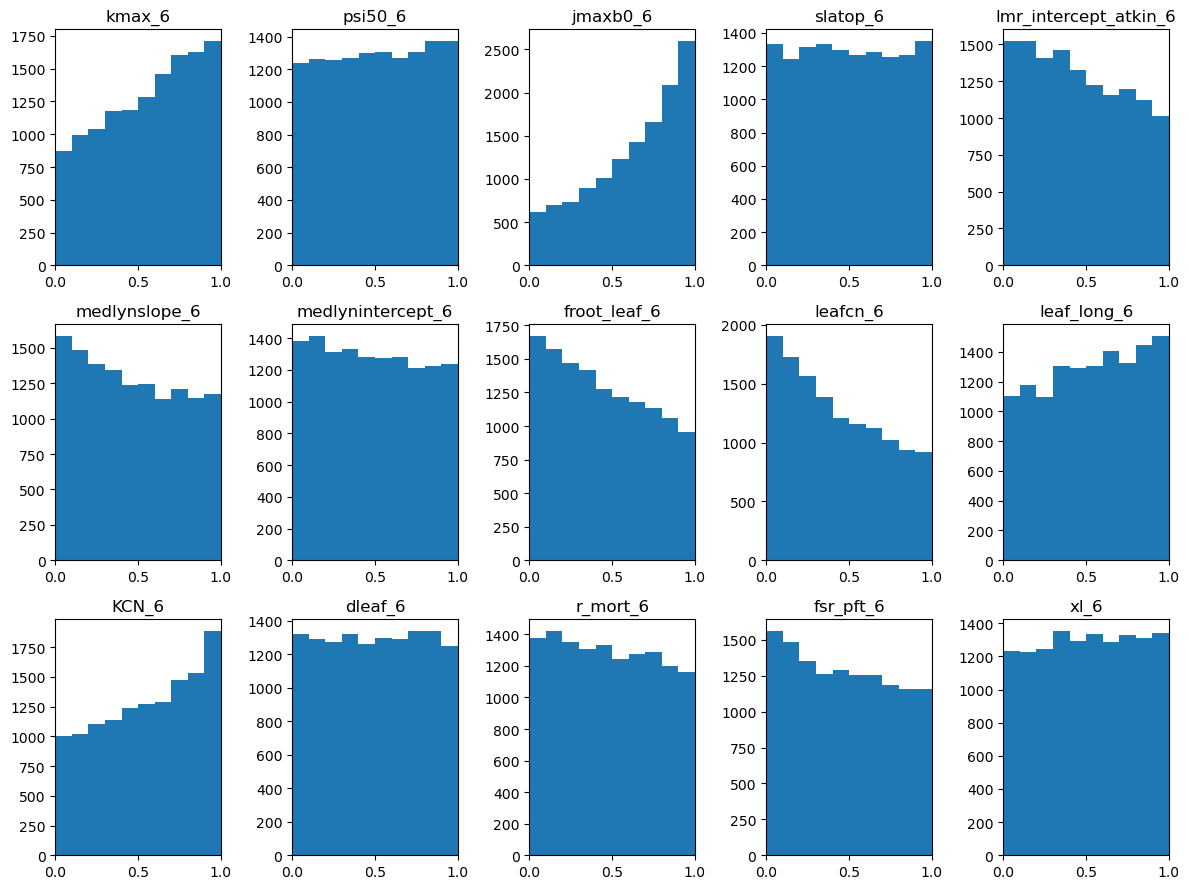

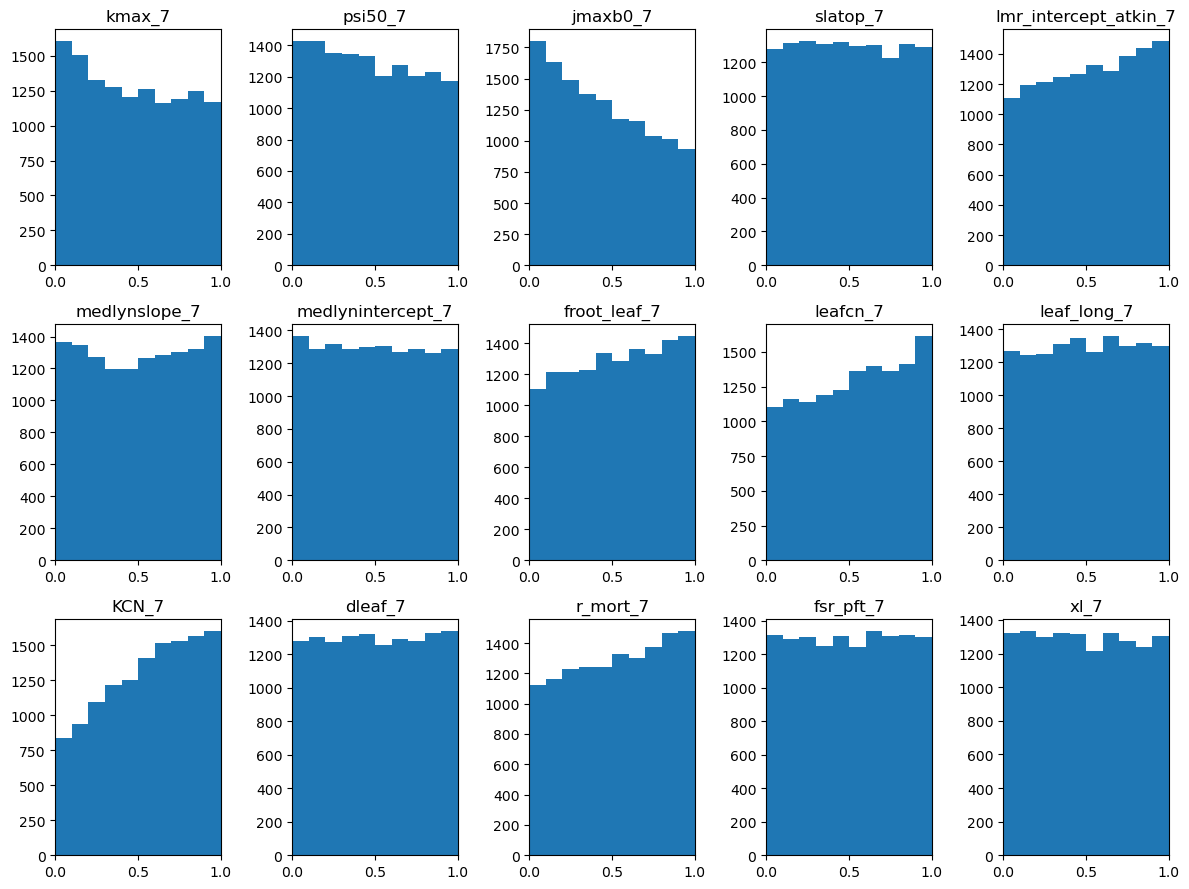

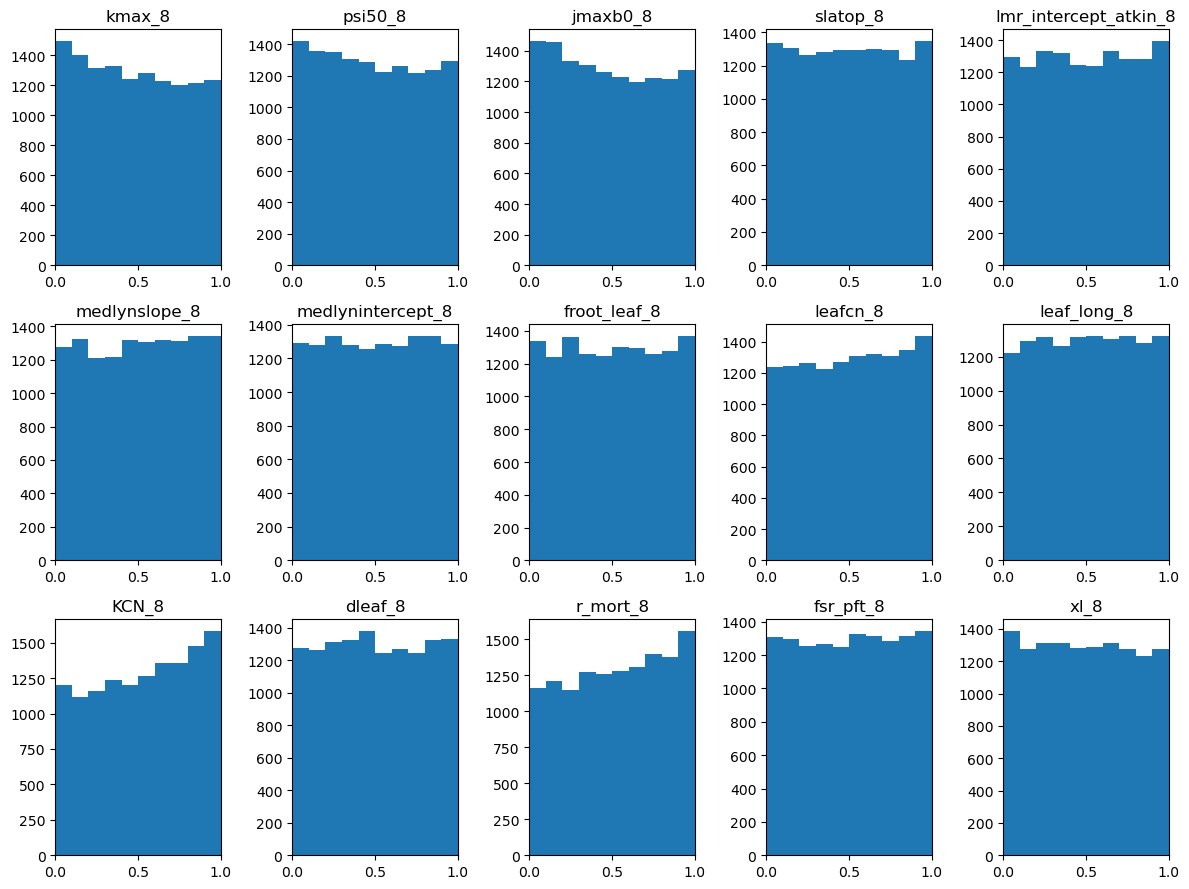

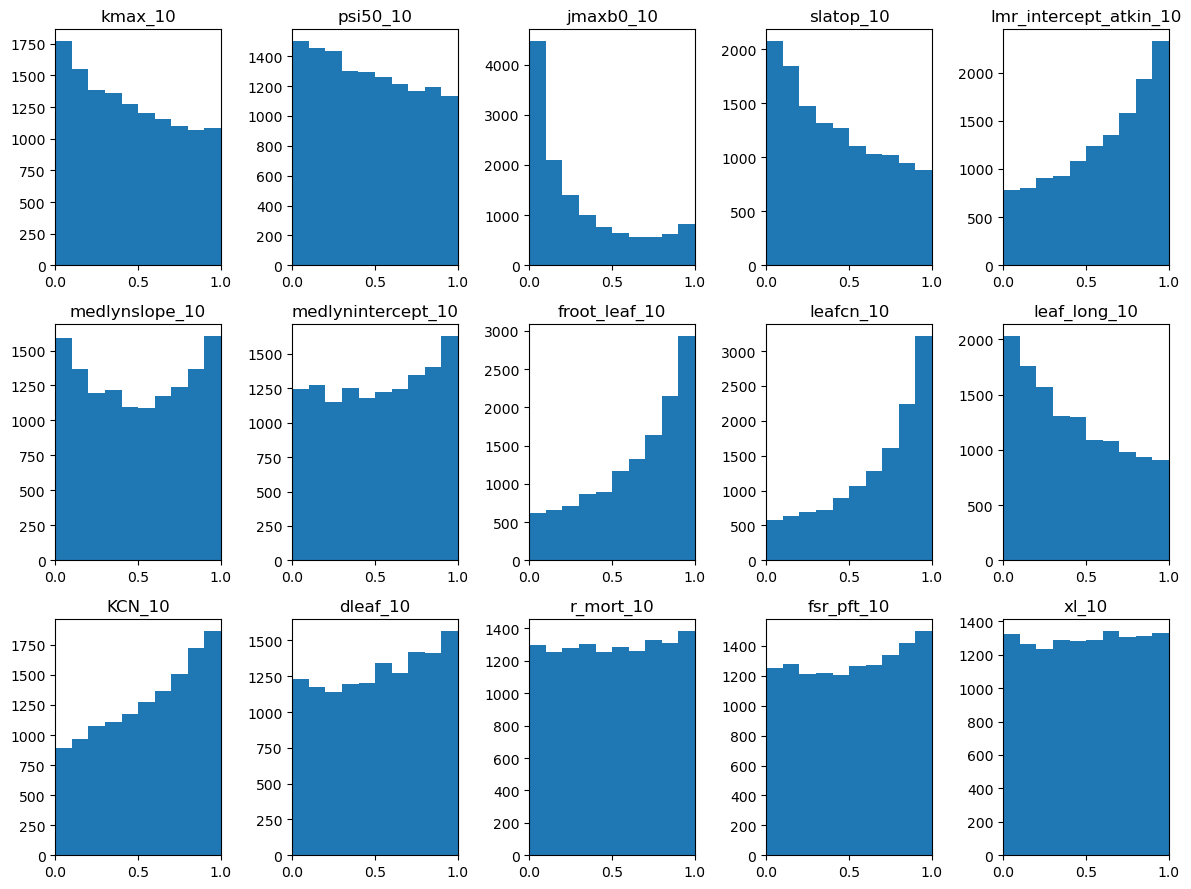

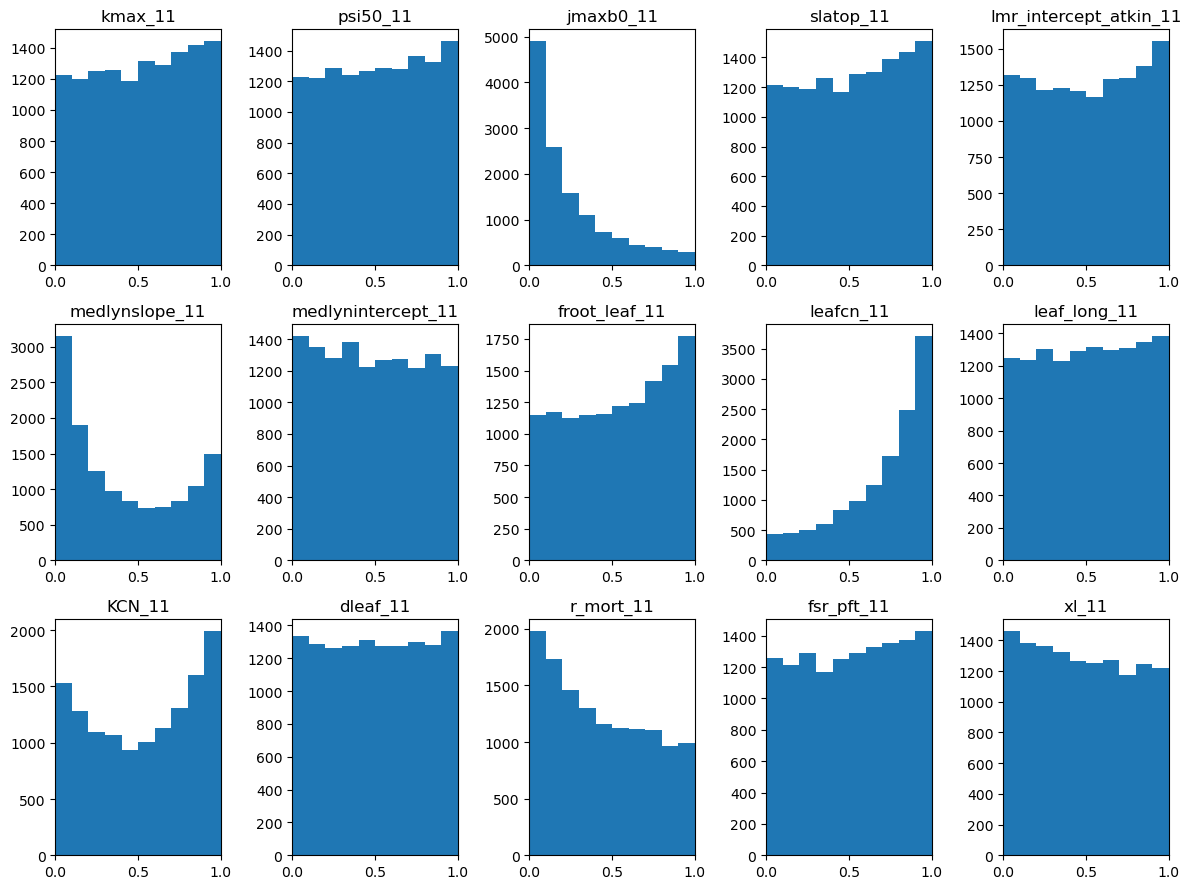

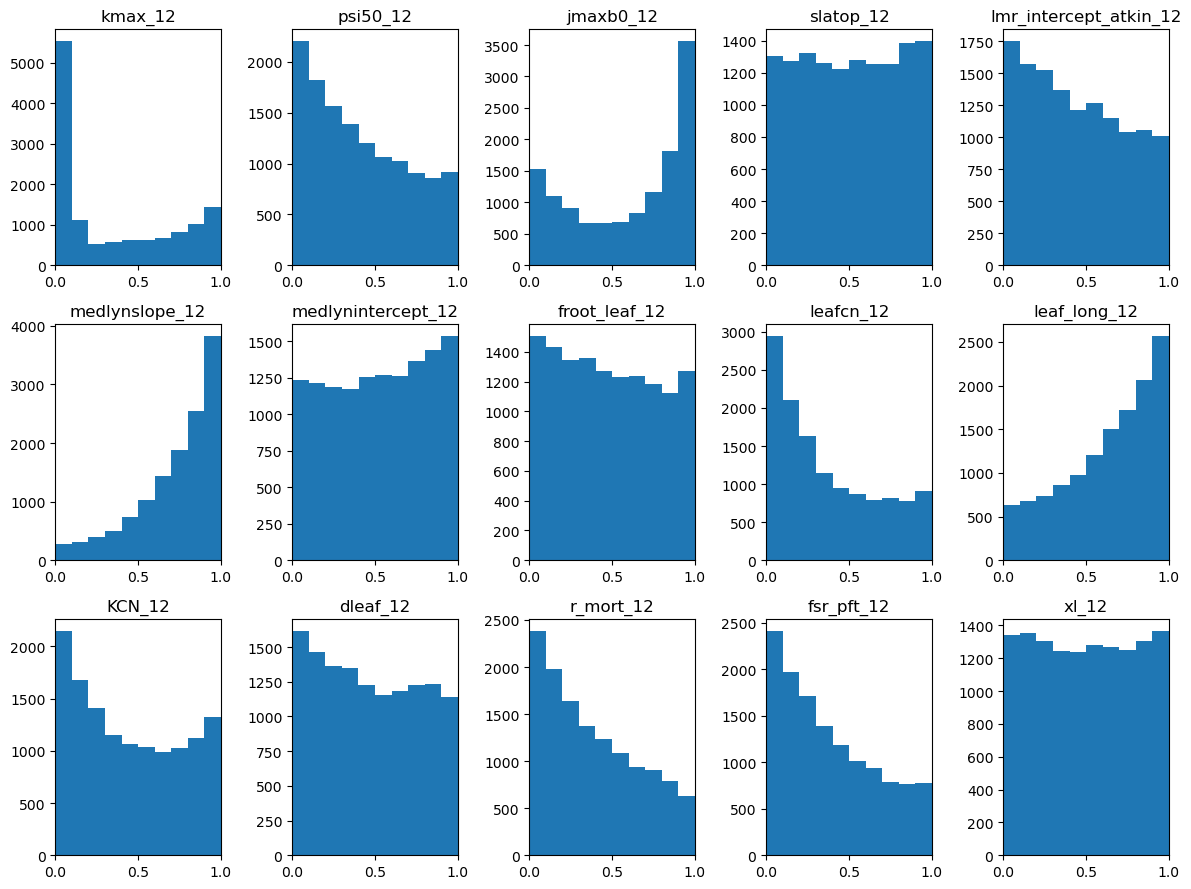

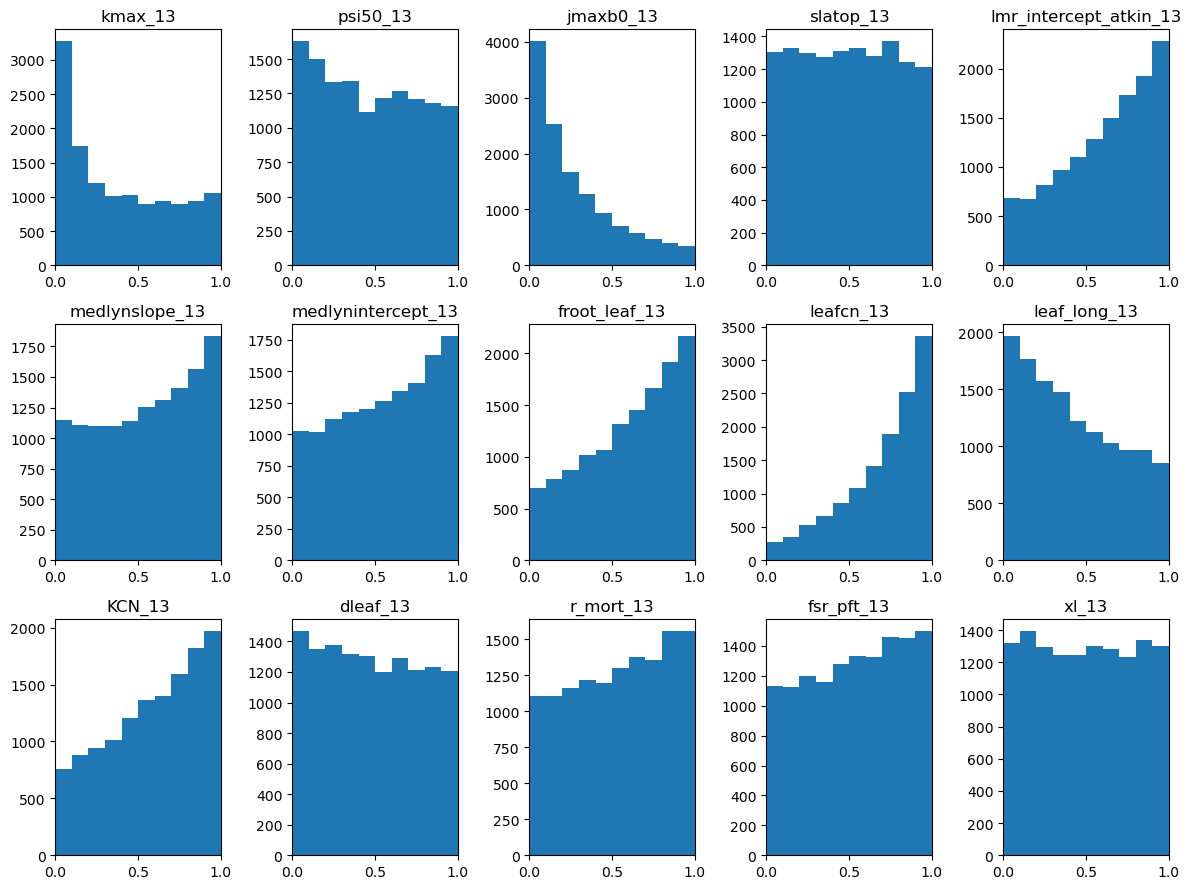

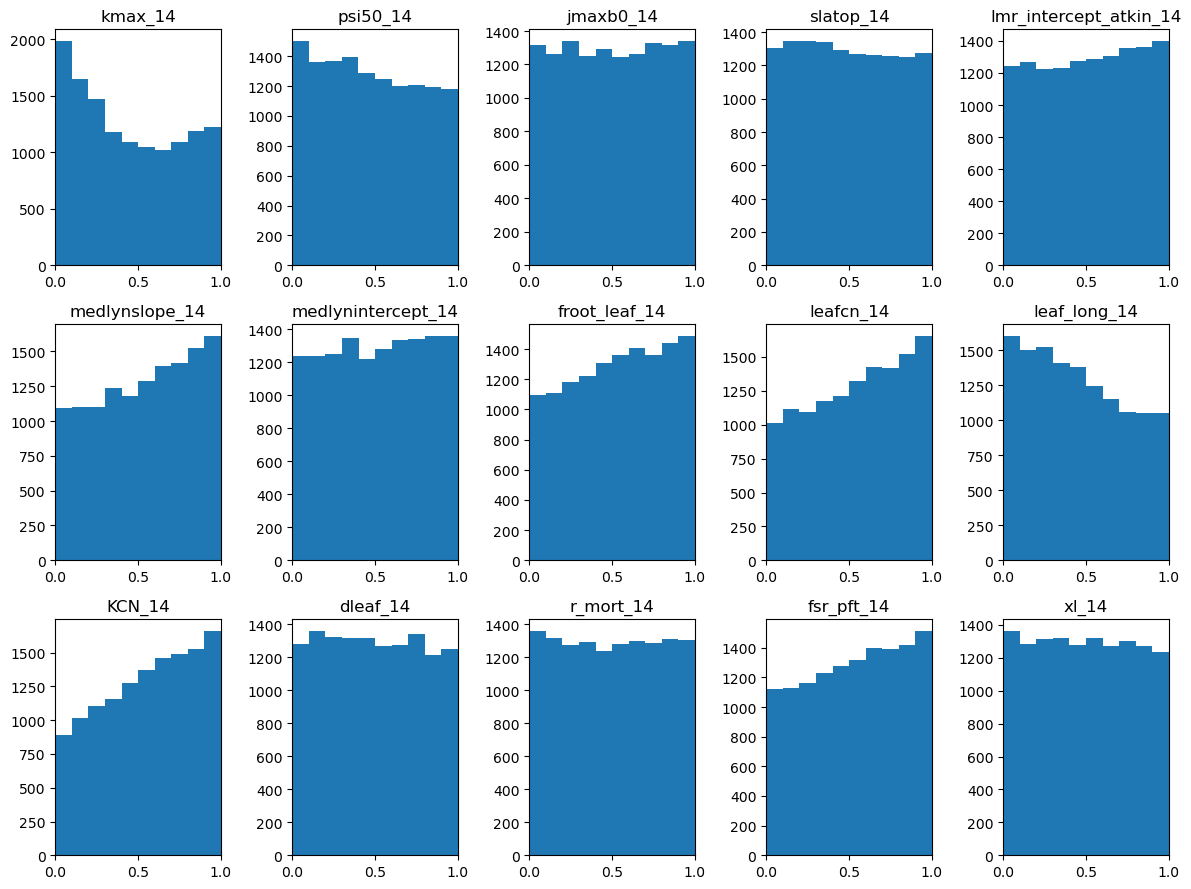

In [12]:
# PFT parameters by Biome

for pft in [1,2,3,4,5,6,7,8,10,11,12,13,14]:
    pft_param_names = [f"{param}_{pft}" for param in pft_params]
    plt.figure(figsize=(12,9))
    for i in range(len(pft_params)):
        plt.subplot(3,5,i+1)
        plt.hist(master_sample[pft_param_names[i]])
        plt.title(pft_param_names[i])
        plt.xlim([0,1])
    plt.tight_layout()
    plt.savefig('../figs/posteriors_pftparams_pft'+str(pft)+'.png')